### Let's use Pandas and standard python libraries instead of graphlab

In [1]:
import pandas as pd
import numpy as np
%matplotlib inline
import matplotlib.pyplot as plt
plt.style.use('ggplot')
pd.options.display.mpl_style = 'default';

# set figsize for all figures in notebook
plt.rcParams["figure.figsize"] = [12.0, 9.0]

/usr/local/lib/python2.7/dist-packages/IPython/core/interactiveshell.py:2885: FutureWarning: 
mpl_style had been deprecated and will be removed in a future version.
Use `matplotlib.pyplot.style.use` instead.

  exec(code_obj, self.user_global_ns, self.user_ns)


### Load some house value vs. crime rate data

Dataset is from Philadelphia, PA and includes average house sales price in a number of neighborhoods.  The attributes of each neighborhood we have include the crime rate ('CrimeRate'), miles from Center City ('MilesPhila'), town name ('Name'), and county name ('County').

In [2]:
sales = pd.read_csv('./Philadelphia_Crime_Rate_noNA.csv')

In [3]:
sales.head()

,HousePrice,"HsPrc ($10,000)",CrimeRate,MilesPhila,PopChg,Name,County
0,140463,14.0463,29.7,10.0,-1.0,Abington,Montgome
1,113033,11.3033,24.1,18.0,4.0,Ambler,Montgome
2,124186,12.4186,19.5,25.0,8.0,Aston,Delaware
3,110490,11.0490,49.4,25.0,2.7,Bensalem,Bucks
4,79124,7.9124,54.1,19.0,3.9,Bristol B.,Bucks


## Exploring the data 

The house price in a town is correlated with the crime rate of that town. Low crime towns tend to be associated with higher house prices and vice versa.

/usr/local/lib/python2.7/dist-packages/matplotlib/font_manager.py:1288: UserWarning: findfont: Font family [u'monospace'] not found. Falling back to Bitstream Vera Sans
  (prop.get_family(), self.defaultFamily[fontext]))


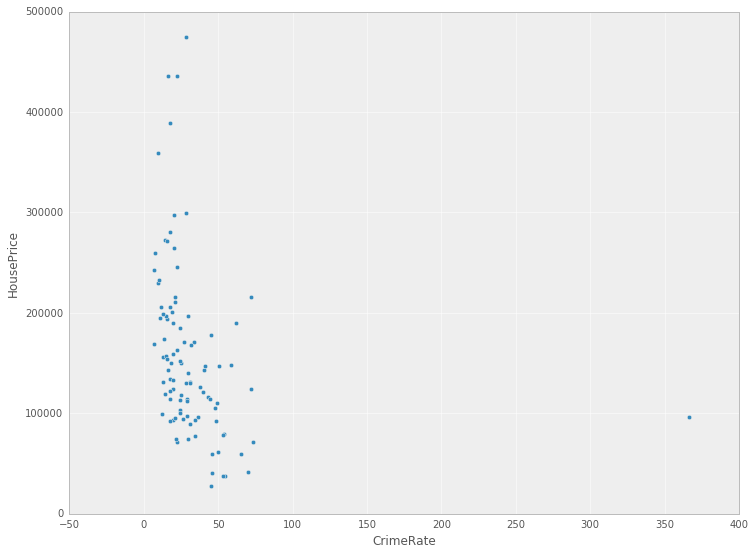

In [4]:
sales.plot(kind="scatter", x="CrimeRate", y="HousePrice");

## Fit the regression model using crime as the feature

Using [Scikit-learn](http://scikit-learn.org/) library to build the model

In [5]:
from sklearn import linear_model

In [6]:
crime_model = linear_model.LinearRegression()

In [7]:
crime_model.fit(sales['CrimeRate'].values[:, np.newaxis], sales['HousePrice'].values);

## Let's see what our fit looks like

Matplotlib is a Python plotting library that is also useful for plotting.  You can install it with:

'pip install matplotlib'

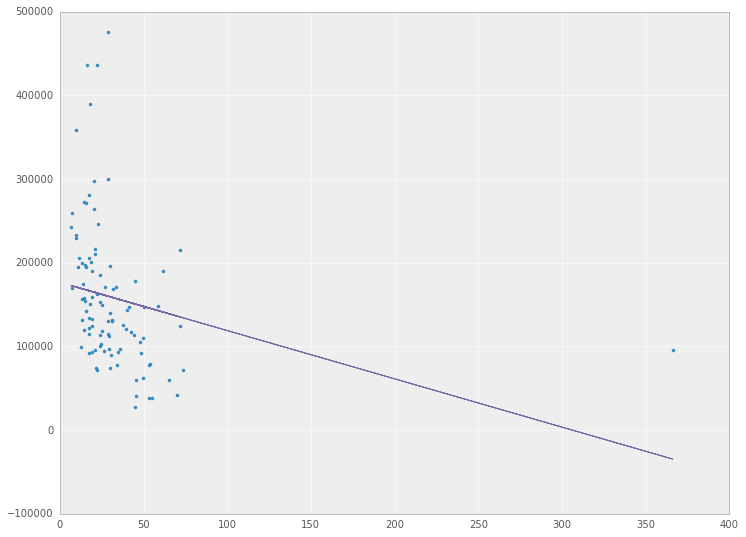

In [18]:
plt.plot(sales['CrimeRate'],sales['HousePrice'],'.',
        sales['CrimeRate'],crime_model.predict(sales['CrimeRate'].values[:, np.newaxis]),'-');

Above: blue dots are original data, green line is the fit from the simple regression.

# Remove Center City and redo the analysis

Center City is the one observation with an extremely high crime rate, yet house prices are not very low.  This point does not follow the trend of the rest of the data very well.  A question is how much including Center City is influencing our fit on the other datapoints.  Let's remove this datapoint and see what happens.

In [9]:
sales_noCC = sales[sales['MilesPhila'] != 0.0] 

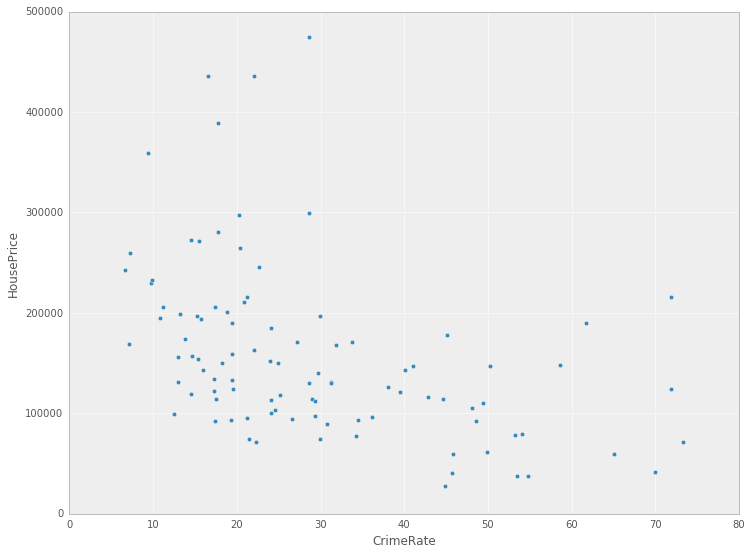

In [10]:
sales_noCC.plot(kind='scatter', x="CrimeRate", y="HousePrice");

### Refit our simple regression model on this modified dataset:

In [11]:
crime_model_noCC = linear_model.LinearRegression()
crime_model_noCC.fit(sales_noCC['CrimeRate'].values[:, np.newaxis], sales_noCC['HousePrice'].values);

### Look at the fit:

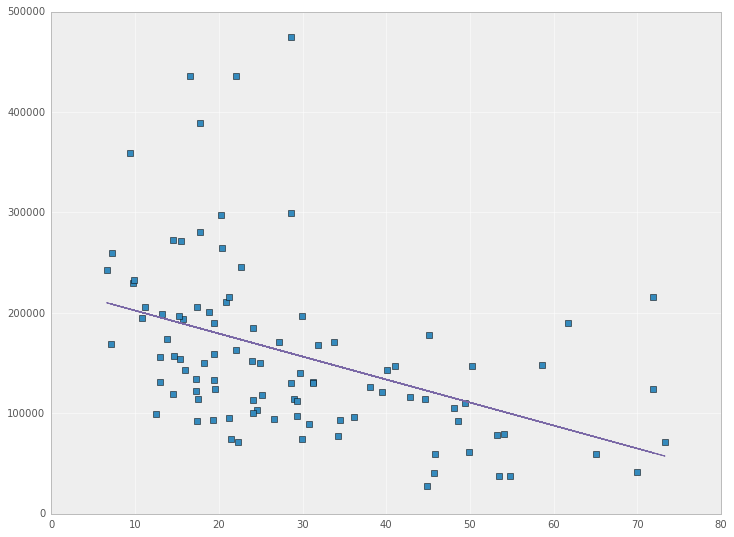

In [19]:
plt.plot(sales_noCC['CrimeRate'],sales_noCC['HousePrice'],'s',
        sales_noCC['CrimeRate'],crime_model_noCC.predict(sales_noCC['CrimeRate'].values[:, np.newaxis]),'-');

# Compare coefficients for full-data fit versus no-Center-City fit

Visually, the fit seems different, but let's quantify this by examining the estimated coefficients of our original fit and that of the modified dataset with Center City removed.

In [13]:
print "Slope : ", crime_model.coef_[0]
print "Intercept : ", crime_model.intercept_

Slope :  -576.908127682
Intercept :  176629.408107


In [14]:
print "Slope : ", crime_model_noCC.coef_[0]
print "Intercept : ", crime_model_noCC.intercept_

Slope :  -2288.68942995
Intercept :  225233.551839


Above: We see that for the "no Center City" version, per unit increase in crime, the predicted decrease in house prices is 2,287.  In contrast, for the original dataset, the drop is only 576 per unit increase in crime.  This is significantly different!

**High leverage points:**
Center City is said to be a "high leverage" point because it is at an extreme x value where there are not other observations.  As a result, recalling the closed-form solution for simple regression, this point has the *potential* to dramatically change the least squares line since the center of x mass is heavily influenced by this one point and the least squares line will try to fit close to that outlying (in x) point.  If a high leverage point follows the trend of the other data, this might not have much effect.  On the other hand, if this point somehow differs, it can be strongly influential in the resulting fit.

**Influential observations:**  
An influential observation is one where the removal of the point significantly changes the fit.  As discussed above, high leverage points are good candidates for being influential observations, but need not be.  Other observations that are *not* leverage points can also be influential observations (e.g., strongly outlying in y even if x is a typical value).

## Remove high-value outlier neighborhoods and redo analysis

Based on the discussion above, a question is whether the outlying high-value towns are strongly influencing the fit.  Let's remove them and see what happens.

In [15]:
sales_nohighend = sales_noCC[sales_noCC['HousePrice'] < 350000] 
crime_model_nohighend = linear_model.LinearRegression()
crime_model_nohighend.fit(sales_nohighend['CrimeRate'].values[:, np.newaxis], sales_nohighend['HousePrice'].values);

### Do the coefficients change much?

In [16]:
print "Slope : ", crime_model_nohighend.coef_[0]
print "Intercept : ", crime_model_nohighend.intercept_

Slope :  -1838.56264859
Intercept :  199098.85267


In [17]:
print "Slope : ", crime_model_noCC.coef_[0]
print "Intercept : ", crime_model_noCC.intercept_

Slope :  -2288.68942995
Intercept :  225233.551839


Above: We see that removing the outlying high-value neighborhoods has *some* effect on the fit, but not nearly as much as our high-leverage Center City datapoint.